In [1]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Read the dataset:

In [2]:
tweets = pd.read_csv('./tweets_processed.csv', sep=',')
tweets['text']=tweets['whole_tweet']

Showing some dataset rows

In [3]:
tweets.head(2)

,tweet_id,airline_sentiment,whole_tweet,emoticon,mentions,hashtags,airline,n_words,n_words_mayus,n_words_mayus_len,n_suspensivos,n_exclamations,n_questions,len_tw,text
0,926419989107798016,neutral,trabajar en ryanair como tma empleo,[],[],"['Ryanair', 'TMA:', 'empleo']",['ryanair'],7,1,5,0,0,0,35,trabajar en ryanair como tma empleo
1,934854385577943041,neutral,cuando gusten en cancun se viaja y disfruta de...,[],[],[],[],12,0,0,0,0,0,63,cuando gusten en cancun se viaja y disfruta de...


Select only interestig fields:

In [4]:
data = tweets[['text','airline_sentiment']]

Clean up the dataset, conidering only positive and negative tweets:

In [5]:
#data = data[data.airline_sentiment != "neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['airline_sentiment'] == 'positive'].size)
print(data[ data['airline_sentiment'] == 'negative'].size)

2978
7538


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Tokenization:

In [20]:
max_fatures = 10000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

## Neural network:


In [21]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 59, 128)           1280000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 59, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 591       
Total params: 1,535,391
Trainable params: 1,535,391
Non-trainable params: 0
_________________________________________________________________
None


declaring dataset

In [28]:
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.4, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4720, 59) (4720, 3)
(3147, 59) (3147, 3)


Selecting some data for training and some for validation

In [29]:
#X_val = X_train[:500]
#Y_val = Y_train[:500]

In [30]:
#partial_X_train = X_train[500:]
#partial_Y_train = Y_train[500:]

## Train the network:

In [31]:
batch_size = 512
history = model.fit(X_train, 
                    Y_train, 
                    epochs = 10, 
                    batch_size=batch_size, 
                    validation_data=(X_test, Y_test))

Train on 4720 samples, validate on 3147 samples
Epoch 1/10
4720/4720 [==============================] - 5s 1ms/step - loss: 0.2271 - acc: 0.9070 - val_loss: 1.2659 - val_acc: 0.6212
Epoch 2/10
4720/4720 [==============================] - 5s 1ms/step - loss: 0.2164 - acc: 0.9140 - val_loss: 1.2878 - val_acc: 0.6130
Epoch 3/10
4720/4720 [==============================] - 5s 1ms/step - loss: 0.2207 - acc: 0.9117 - val_loss: 1.3076 - val_acc: 0.6155
Epoch 4/10
4720/4720 [==============================] - 5s 1ms/step - loss: 0.2065 - acc: 0.9148 - val_loss: 1.4474 - val_acc: 0.6235
Epoch 5/10
4720/4720 [==============================] - 5s 1ms/step - loss: 0.2028 - acc: 0.9195 - val_loss: 1.4324 - val_acc: 0.6155
Epoch 6/10
4720/4720 [==============================] - 5s 1ms/step - loss: 0.1885 - acc: 0.9220 - val_loss: 1.4618 - val_acc: 0.6114
Epoch 7/10
4720/4720 [==============================] - 5s 1ms/step - loss: 0.1967 - acc: 0.9178 - val_loss: 1.5336 - val_acc: 0.6168
Epoch 8/10
472

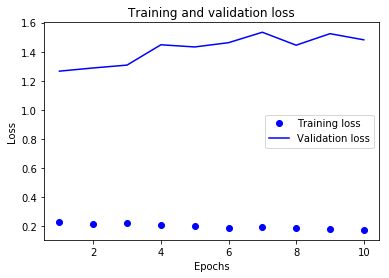

In [32]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

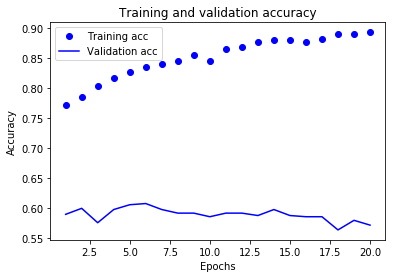

In [19]:
plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Validation

In [18]:
X_validate=X_test
Y_validate=Y_test
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 40.38179148311307 %
neg_acc 70.68825910931174 %
